## Credit risk scoring project

* We will use machine learning to calculate the risk of default
* It is a binary classification problem: The target is positive ("1") if the customer defaults and negative ("0") otherwise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

## Data Cleaning

In [2]:
df = pd.read_csv("input/CreditScoring.csv")

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


#### Decoding the numbers into categories

In [5]:
status_values = {
    1: "ok",
    2:"default",
    0: "unk"
}
df.status = df.status.map(status_values)

In [6]:
home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "others",
    0: "unk"
}

df.home = df.home.map(home_values)

In [7]:
marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unk"
}

df.marital = df.marital.map(marital_values)

In [8]:
records_values = {
    1: "no",
    2: "yes",
    0: "unk"
}

df.records = df.records.map(records_values)

In [9]:
job_values = {
    1: "fixed",
    2: "parttime",
    3: "freelance",
    4: "others",
    0: "unk"
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


#### Looking at numeric columns

In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


* 99999999 is how missing values are encoding in the dataset

In [12]:
for idx in ["income", "assets", "debt"]:
    df[idx] = df[idx].replace(99999999, np.nan)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [14]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [15]:
df = df[df["status"] != "unk"].reset_index(drop=True)

## Data Preparation

In [16]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [17]:
print(len(df_train), len(df_val), len(df_test))

2672 891 891


In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = (df_train.status == "default").astype("int").values
y_val = (df_val.status == "default").astype("int").values
y_test = (df_test.status == "default").astype("int").values

In [20]:
del df_train["status"]
del df_val["status"]
del df_test["status"]

In [21]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [22]:
dict_train = df_train.to_dict(orient="records")
dict_val = df_val.to_dict(orient="records")

In [23]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [24]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,parttime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


## Decision Trees

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = dt.predict_proba(X_train)[:,1]

In [28]:
print(f'AUC training set: {roc_auc_score(y_train, y_pred)}')

AUC training set: 1.0


In [29]:
y_pred = dt.predict_proba(X_val)[:,1]

In [30]:
print(f'AUC validation set: {roc_auc_score(y_val, y_pred):.2f}')

AUC validation set: 0.66


* Trying a different value for the max_depth parameter
* Default max_depth parameter is None, which means that the three can grow as large as possible 
* To visualize the tree, we can use the export_text function

In [31]:
from sklearn.tree import export_text

In [32]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [33]:
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: 0
|   |--- job=parttime >  0.50
|   |   |--- class: 1



In [34]:
y_pred = dt.predict_proba(X_train)[:,1]
print(f'AUC training set: {roc_auc_score(y_train, y_pred):.2f}')

AUC training set: 0.71


In [35]:
y_pred = dt.predict_proba(X_val)[:,1]
print(f'AUC validation set: {roc_auc_score(y_val, y_pred):.2f}')

AUC validation set: 0.67


In [36]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [37]:
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=parttime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=parttime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



In [38]:
y_pred = dt.predict_proba(X_train)[:,1]
print(f'AUC training set: {roc_auc_score(y_train, y_pred):.2f}')

AUC training set: 0.78


In [39]:
y_pred = dt.predict_proba(X_val)[:,1]
print(f'AUC validation set: {roc_auc_score(y_val, y_pred):.2f}')

AUC validation set: 0.74


## Decision trees parameter tuning
* Selecting max_depth
* Selecting min_samples_leaf

In [40]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15 ,20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print(f'Depth: {depth}, AUC: {auc:.3f}')

Depth: 1, AUC: 0.606
Depth: 2, AUC: 0.669
Depth: 3, AUC: 0.739
Depth: 4, AUC: 0.761
Depth: 5, AUC: 0.767
Depth: 6, AUC: 0.747
Depth: 10, AUC: 0.689
Depth: 15, AUC: 0.674
Depth: 20, AUC: 0.643
Depth: None, AUC: 0.658


In [41]:
scores = []

In [42]:
for m in [4, 5, 6]:
    print(f'm: {m}')
    
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f's: {s}, AUC: {auc:.3f}')
        scores.append((m, s, auc))
    print()


m: 4
s: 1, AUC: 0.761
s: 5, AUC: 0.761
s: 10, AUC: 0.761
s: 15, AUC: 0.764
s: 20, AUC: 0.761
s: 50, AUC: 0.753
s: 100, AUC: 0.756
s: 200, AUC: 0.747

m: 5
s: 1, AUC: 0.767
s: 5, AUC: 0.768
s: 10, AUC: 0.762
s: 15, AUC: 0.772
s: 20, AUC: 0.774
s: 50, AUC: 0.768
s: 100, AUC: 0.763
s: 200, AUC: 0.759

m: 6
s: 1, AUC: 0.749
s: 5, AUC: 0.760
s: 10, AUC: 0.778
s: 15, AUC: 0.785
s: 20, AUC: 0.774
s: 50, AUC: 0.772
s: 100, AUC: 0.776
s: 200, AUC: 0.768



In [43]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
19,6,15,0.785474
18,6,10,0.777803
22,6,100,0.776434
20,6,20,0.774279
12,5,20,0.774028


In [44]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.749
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
50                0.753  0.768  0.772
100               0.756  0.763  0.776
200               0.747  0.759  0.768

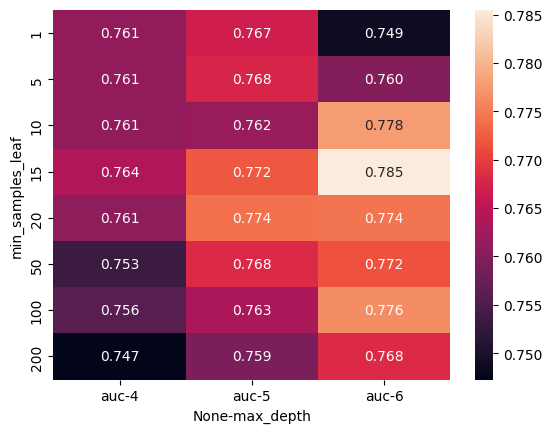

In [45]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')
plt.show()

We have found the best parameters: max_depth=6, min_samples_leaf=15

In [46]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Ensembles model and random forest 

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=3)

In [49]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred).round(3)

0.781

* To see how many trees we need, we can iterate over different values for n_estimators and see its effect on the AUC

In [50]:
aucs = []
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)
    print(f'i: {i}, AUC: {auc:.3f}')

i: 10, AUC: 0.781
i: 20, AUC: 0.801
i: 30, AUC: 0.813
i: 40, AUC: 0.815
i: 50, AUC: 0.816
i: 60, AUC: 0.817
i: 70, AUC: 0.818
i: 80, AUC: 0.818
i: 90, AUC: 0.820
i: 100, AUC: 0.819
i: 110, AUC: 0.819
i: 120, AUC: 0.821
i: 130, AUC: 0.822
i: 140, AUC: 0.822
i: 150, AUC: 0.820
i: 160, AUC: 0.820
i: 170, AUC: 0.819
i: 180, AUC: 0.820
i: 190, AUC: 0.820
i: 200, AUC: 0.820


[]

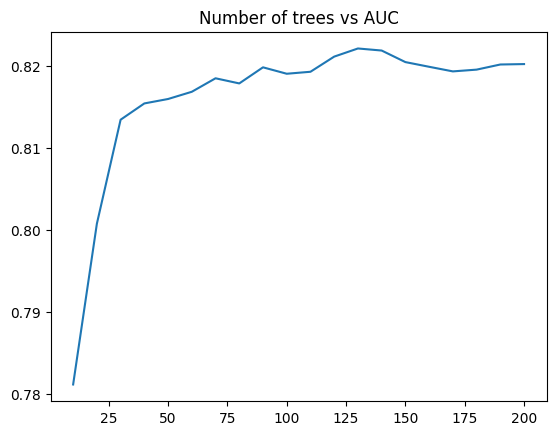

In [51]:
plt.plot(range(10, 201, 10), aucs)
plt.title("Number of trees vs AUC")
plt.plot()

#### Parameter tuning for random forest

max_depth tuning 

In [52]:
all_aucs = {}

for depth in [5, 10, 20]:
    print(f'depth: {depth}')
    aucs = []
    for i in range (10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print(f'i: {i}, AUC {auc:.3f}')
        aucs.append(auc)
        
    all_aucs[depth] = aucs
    print()
    

depth: 5
i: 10, AUC 0.788
i: 20, AUC 0.798
i: 30, AUC 0.800
i: 40, AUC 0.800
i: 50, AUC 0.800
i: 60, AUC 0.801
i: 70, AUC 0.802
i: 80, AUC 0.803
i: 90, AUC 0.804
i: 100, AUC 0.804
i: 110, AUC 0.807
i: 120, AUC 0.806
i: 130, AUC 0.808
i: 140, AUC 0.807
i: 150, AUC 0.807
i: 160, AUC 0.807
i: 170, AUC 0.807
i: 180, AUC 0.807
i: 190, AUC 0.807
i: 200, AUC 0.807

depth: 10
i: 10, AUC 0.791
i: 20, AUC 0.808
i: 30, AUC 0.812
i: 40, AUC 0.818
i: 50, AUC 0.817
i: 60, AUC 0.819
i: 70, AUC 0.820
i: 80, AUC 0.820
i: 90, AUC 0.820
i: 100, AUC 0.821
i: 110, AUC 0.823
i: 120, AUC 0.823
i: 130, AUC 0.825
i: 140, AUC 0.824
i: 150, AUC 0.824
i: 160, AUC 0.825
i: 170, AUC 0.825
i: 180, AUC 0.825
i: 190, AUC 0.825
i: 200, AUC 0.825

depth: 20
i: 10, AUC 0.776
i: 20, AUC 0.803
i: 30, AUC 0.813
i: 40, AUC 0.817
i: 50, AUC 0.815
i: 60, AUC 0.813
i: 70, AUC 0.814
i: 80, AUC 0.815
i: 90, AUC 0.814
i: 100, AUC 0.815
i: 110, AUC 0.817
i: 120, AUC 0.816
i: 130, AUC 0.818
i: 140, AUC 0.818
i: 150, AUC 0.818
i: 160

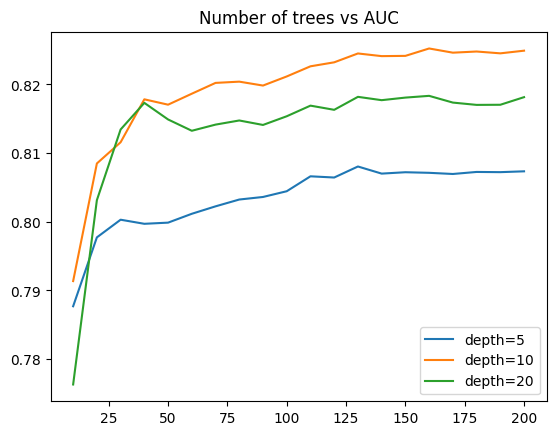

In [53]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label = 'depth=5')
plt.plot(num_trees, all_aucs[10], label = 'depth=10')
plt.plot(num_trees, all_aucs[20], label = 'depth=20')
plt.legend()
plt.title('Number of trees vs AUC')
plt.show()

In [54]:
all_aucs = {}

for m in [3, 5, 10]:
    print(f'min_samples_leaf: {m}')
    aucs = []
    
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f'i: {i}, AUC {auc:.3f}')
        aucs.append(auc)
        
    all_aucs[m] = aucs
    print()
    

min_samples_leaf: 3
i: 10, AUC 0.811
i: 30, AUC 0.823
i: 50, AUC 0.823
i: 70, AUC 0.822
i: 90, AUC 0.823
i: 110, AUC 0.823
i: 130, AUC 0.824
i: 150, AUC 0.825
i: 170, AUC 0.825
i: 190, AUC 0.825

min_samples_leaf: 5
i: 10, AUC 0.813
i: 30, AUC 0.818
i: 50, AUC 0.821
i: 70, AUC 0.822
i: 90, AUC 0.822
i: 110, AUC 0.825
i: 130, AUC 0.825
i: 150, AUC 0.825
i: 170, AUC 0.825
i: 190, AUC 0.826

min_samples_leaf: 10
i: 10, AUC 0.810
i: 30, AUC 0.822
i: 50, AUC 0.822
i: 70, AUC 0.819
i: 90, AUC 0.820
i: 110, AUC 0.820
i: 130, AUC 0.821
i: 150, AUC 0.820
i: 170, AUC 0.820
i: 190, AUC 0.820



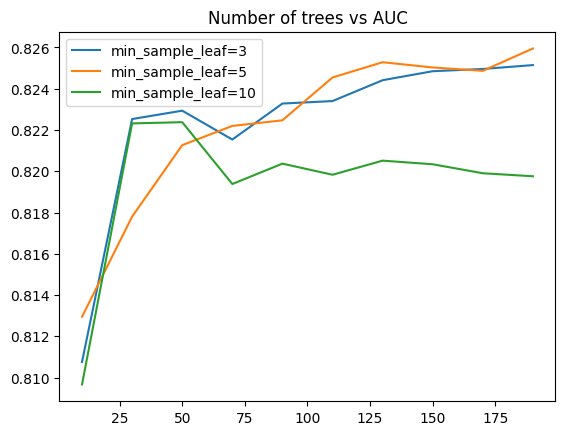

In [55]:
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label = 'min_sample_leaf=3')
plt.plot(num_trees, all_aucs[5], label = 'min_sample_leaf=5')
plt.plot(num_trees, all_aucs[10], label = 'min_sample_leaf=10')
plt.legend()
plt.title('Number of trees vs AUC')
plt.show()

#### The best parameters for random forest for our problem are:
* max_depth=10
* min_samples_leaf=5
* n_estimatores=200

In [56]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=1)

## Gradient boosting and XGBoost

In [57]:
import xgboost as xgb

* Before we can train an XGBoost model, we need to wrap our data into a special data structure for finding splits efficiently (DMatrix)

In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)

In [59]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [60]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

In [115]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [116]:
y_pred = model.predict(dval)

In [117]:
roc_auc_score(y_val, y_pred)

0.7835151727979462

#### Model performance monitoring

In [118]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [119]:
xgb_params = {
    'eta': 0.3, #default value
    'max_depth': 6, #default value
    'min_child_weight': 1, #default value
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

In [120]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

In [122]:
def parse_xgb_outoput(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [123]:
df_scores = parse_xgb_outoput(output)
df_scores.head()

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,10,0.95002,0.81558
2,20,0.97316,0.81775
3,30,0.98772,0.81787
4,40,0.99456,0.81387


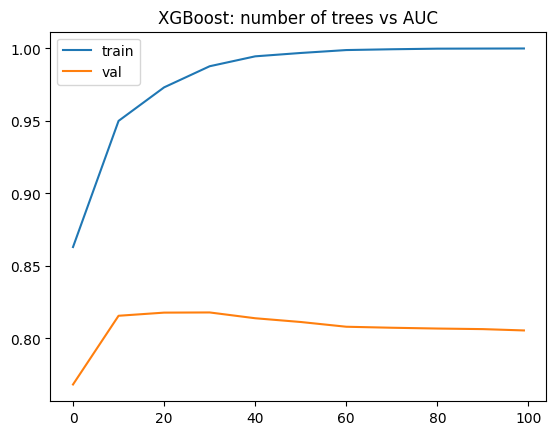

In [124]:
plt.plot(df_scores.num_iter, df_scores.train_auc, label='train')
plt.plot(df_scores.num_iter, df_scores.val_auc, label='val')
plt.legend()
plt.title('XGBoost: number of trees vs AUC')
plt.show()

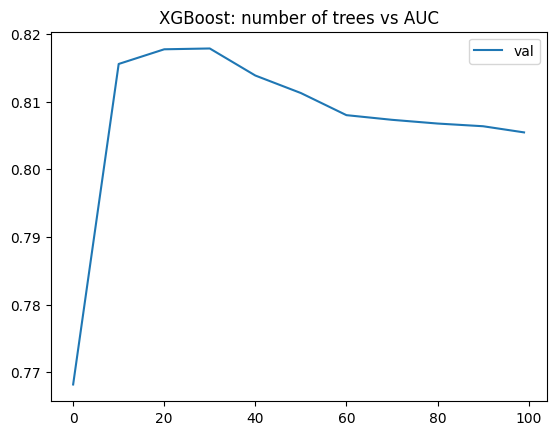

In [126]:
plt.plot(df_scores.num_iter, df_scores.val_auc, label='val')
plt.legend()
plt.title('XGBoost: number of trees vs AUC')
plt.show()

## XGBoost parameter tuning

Tuning eta

In [136]:
scores = {}

In [156]:
%%capture output

xgb_params = {
    'eta': 0.01, # Multiple parameters were used to add them to the dictionary -> scores.keys()
    'max_depth': 6, #default value
    'min_child_weight': 1, #default value
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

In [146]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_outoput(output)
key

'eta=0.01'

In [147]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

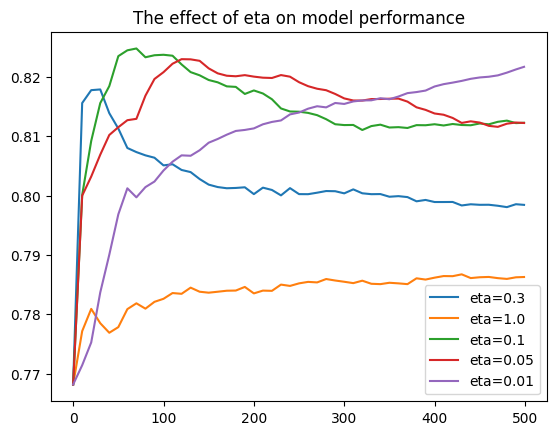

In [150]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.title('The effect of eta on model performance')
plt.show()

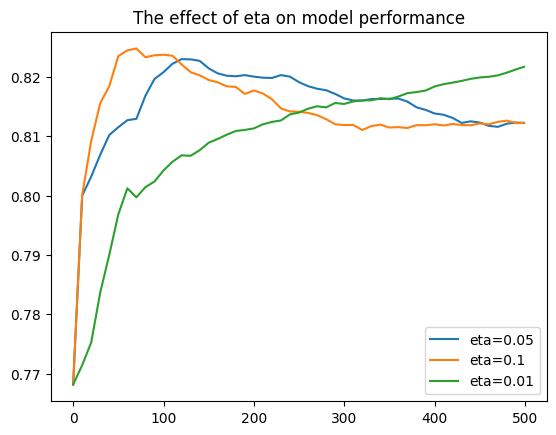

In [154]:
etas = ['eta=0.05', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()
plt.title('The effect of eta on model performance')
plt.show()

Tuning other max_depth

In [163]:
scores = {}

In [181]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10, # Multiple parameters were used to add them to the dictionary -> scores.keys()
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

In [182]:
key = f'max_depth={xgb_params["max_depth"]}'
scores[key] = parse_xgb_outoput(output)
key

'max_depth=10'

In [183]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

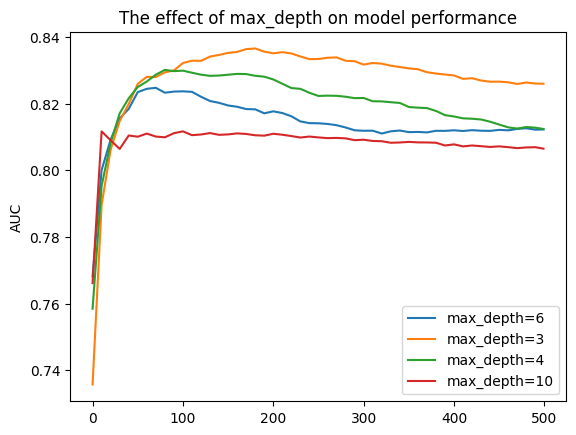

In [184]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.title('The effect of max_depth on model performance')
plt.ylabel('AUC')
plt.show()

In [185]:
del scores['max_depth=10']

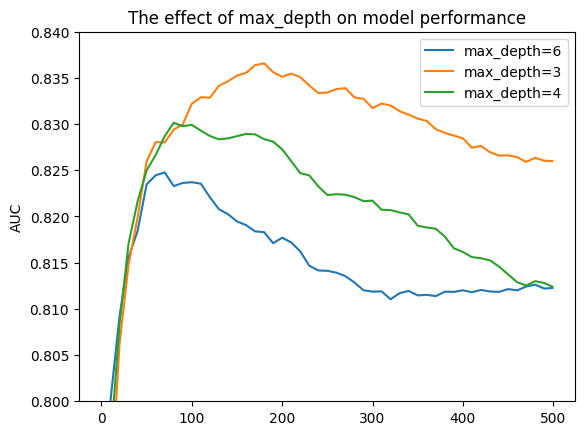

In [186]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.title('The effect of max_depth on model performance')
plt.ylabel('AUC')
plt.ylim(0.8, 0.84)
plt.show()

Tuning min_child_weight

In [187]:
scores = {}

In [194]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 30, # Multiple parameters were used to add them to the dictionary -> scores.keys()
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

In [195]:
key = f'min_child_weight={xgb_params["min_child_weight"]}'
scores[key] = parse_xgb_outoput(output)
key

'min_child_weight=30'

In [196]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

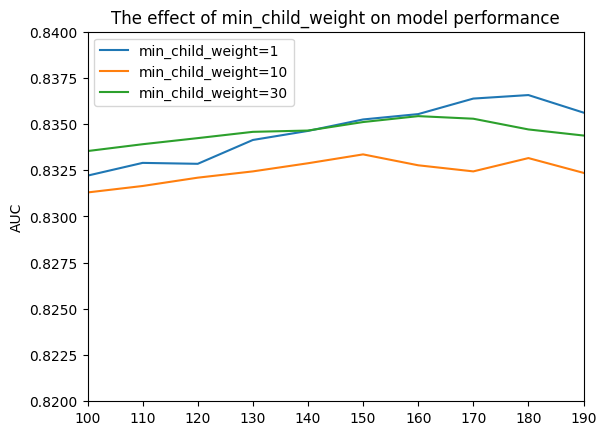

In [202]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.title('The effect of min_child_weight on model performance')
plt.ylabel('AUC')
plt.ylim(0.82, 0.84)
plt.xlim(100, 190)
plt.show()

Final model

In [203]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

model = xgb.train(xgb_params, dtrain, num_boost_round=180)

## Selecting the final model

In [207]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [212]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7850954203095104

In [208]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=1)

In [213]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8253826499721489

In [209]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

model = xgb.train(xgb_params, dtrain, num_boost_round=180)

In [215]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8364807100821002

### Training our final model

In [217]:
df_train_full = df_train_full.reset_index(drop=True)

In [218]:
df_train_full.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,default,8,others,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750


In [223]:
y_train_full = (df_train_full.status == 'default').astype("int").values

In [224]:
del df_train_full['status']

In [232]:
dicts_full_train = df_train_full.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dicts_full_train)

In [233]:
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [238]:
dfull_train = xgb.DMatrix(X_full_train, label=y_train_full, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_) # We do not need label here, because we wont use this for testing, we will evaluate it with scikit-learn

In [240]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread':8,
    'seed': 1,
    'verbosity': 1

}

model = xgb.train(xgb_params, dfull_train, num_boost_round=180)

In [241]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8318080738966815